# 連続制御のActorCriticを実装する　〜Cliped Double Net化〜

In [1]:
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gym
from gym.wrappers import RecordVideo
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

## パラメータの設定

In [2]:
gym_game_name = 'Pendulum-v1'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
result_dir_path = Path('result')
model_dir_path = Path('model')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

## モデルの構築

In [ ]:
class DualCriticNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim):

        super().__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)

        self.linear4 = nn.Linear(input_dim, hidden_dim)
        self.linear5 = nn.Linear(hidden_dim, hidden_dim)
        self.linear6 = nn.Linear(hidden_dim, output_dim)

    def forward(self, state, action):
        xu = torch.cat([state, action], 1)
        
        x1 = F.relu(self.linear1(xu))
        x1 = F.relu(self.linear2(x1))
        x1 = self.linear3(x1)

        x2 = F.relu(self.linear4(xu))
        x2 = F.relu(self.linear5(x2))
        x2 = self.linear6(x2)

        return x1, x2

In [6]:
LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6

class ActorNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim, action_scale):

        super().__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean_linear = nn.Linear(hidden_dim, output_dim)
        self.log_std_linear = nn.Linear(hidden_dim, output_dim)

        self.action_scale = torch.tensor(action_scale)
        self.action_bias = torch.tensor(0.)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, mean

    def to(self, device):
        self.action_scale = self.action_scale.to(device)
        self.action_bias = self.action_bias.to(device)
        return super().to(device)

In [1]:
class ActorDualCriticModel(object):

    def __init__(self, state_dim, action_dim, action_scale, args, device):

        self.gamma = args['gamma']
        self.tau = args['tau']
        self.alpha = args['alpha']

        self.target_update_interval = args['target_update_interval']

        self.device = device

        self.actor_net = ActorNet(input_dim=state_dim, output_dim=action_dim, hidden_dim=args['hiden_dim'], action_scale=action_scale).to(self.device)
        self.critic_net = DualCriticNet(input_dim=state_dim + action_dim, output_dim=1, hidden_dim=args['hiden_dim']).to(self.device)
        self.critic_net_target = DualCriticNet(input_dim=state_dim + action_dim, output_dim=1, hidden_dim=args['hiden_dim']).to(self.device)

        hard_update(self.critic_net_target, self.critic_net)
        convert_network_grad_to_false(self.critic_net_target)

        self.actor_optim = optim.Adam(self.actor_net.parameters())
        self.critic_optim = optim.Adam(self.critic_net.parameters())

    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if not evaluate:
            action, _ = self.actor_net.sample(state)
        else:
            _, action = self.actor_net.sample(state)
        return action.detach().numpy().reshape(-1)

    def update_parameters(self, memory, batch_size, updates):

        state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size=batch_size)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1).to(self.device)
        mask_batch = torch.FloatTensor(mask_batch).unsqueeze(1).to(self.device)

        with torch.no_grad():
            next_state_action, _ = self.actor_net.sample(next_state_batch)
            next_q_values_target1, next_q_values_target2 = self.critic_net_target(next_state_batch, next_state_action)
            next_q_values_target_min = torch.min(next_q_values_target1, next_q_values_target2)
            next_q_value = reward_batch + mask_batch * self.gamma * next_q_values_target_min

        q_values1, q_values2 = self.critic_net(state_batch, action_batch)
        critic_loss1 = F.mse_loss(q_values1, next_q_value)
        critic_loss2 = F.mse_loss(q_values2, next_q_value)
        critic_loss = critic_loss1 + critic_loss2

        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        action, _ = self.actor_net.sample(state_batch)

        q_values1, q_values2 = self.critic_net(state_batch, action)
        q_values_min = torch.min(q_values1, q_values2)

        actor_loss = - q_values_min.mean()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        if updates % self.target_update_interval == 0:
            soft_update(self.critic_net_target, self.critic_net, self.tau)

        return critic_loss.item(), actor_loss.item()

In [8]:
def soft_update(target_net, source_net, tau):
    for target_param, param in zip(target_net.parameters(), source_net.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)


def hard_update(target_net, source_net):
    for target_param, param in zip(target_net.parameters(), source_net.parameters()):
        target_param.data.copy_(param.data)


def convert_network_grad_to_false(network):
    for param in network.parameters():
        param.requires_grad = False

## メモリの構築

In [9]:
class ReplayMemory:

    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, mask):
        if len(self.buffer) < self.memory_size:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, mask)
        self.position = (self.position + 1) % self.memory_size

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.stack, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

## 連続値制御のActorCritiモデルの学習

In [10]:
args = {
    'gamma': 0.99,
    'tau': 0.005,
    'alpha': 0.2,
    'seed': 123456,
    'batch_size': 256,
    'hiden_dim': 256,
    'start_steps': 1000,
    'target_update_interval': 1,
    'memory_size': 100000,
    'epochs': 100,
    'eval_interval': 10
}

In [12]:
env = gym.make(gym_game_name)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [83]:
agent = ActorDualCriticModel(
    state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0], action_scale=env.action_space.high[0],
    args=args, device=device
)
memory = ReplayMemory(args['memory_size'])

episode_reward_list = []
eval_reward_list = []

n_steps = 0
n_update = 0
for i_episode in range(1, args['epochs'] + 1):

    episode_reward = 0
    done = False
    state = env.reset()

    while not done:
        
        if args['start_steps'] > n_steps:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)

        if len(memory) > args['batch_size']:
            agent.update_parameters(memory, args['batch_size'], n_update)
            n_update += 1

        next_state, reward, done, _ = env.step(action)
        n_steps += 1
        episode_reward += reward

        memory.push(state=state, action=action, reward=reward, next_state=next_state, mask=float(not done))

        state = next_state

    episode_reward_list.append(episode_reward)

    if i_episode % args['eval_interval'] == 0:
        avg_reward = 0.
        for _  in range(args['eval_interval']):
            state = env.reset()
            episode_reward = 0
            done = False
            while not done:
                with torch.no_grad():
                    action = agent.select_action(state, evaluate=True)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state
            avg_reward += episode_reward
        avg_reward /= args['eval_interval']
        eval_reward_list.append(avg_reward)

        print("Episode: {}, Eval Avg. Reward: {:.0f}".format(i_episode, avg_reward))

print('Game Done !! Max Reward: {:.2f}'.format(np.max(eval_reward_list)))

torch.save(agent.actor_net.to('cpu').state_dict(), model_dir_path.joinpath(f'{gym_game_name}_actor_dualnet.pth'))

Episode: 10, Eval Avg. Reward: -1411
Episode: 20, Eval Avg. Reward: -676
Episode: 30, Eval Avg. Reward: -431
Episode: 40, Eval Avg. Reward: -563
Episode: 50, Eval Avg. Reward: -180
Episode: 60, Eval Avg. Reward: -270
Episode: 70, Eval Avg. Reward: -501
Episode: 80, Eval Avg. Reward: -188
Episode: 90, Eval Avg. Reward: -182
Episode: 100, Eval Avg. Reward: -191
Game Done !! Max Reward: -179.88


## 学習時の評価報酬の可視化

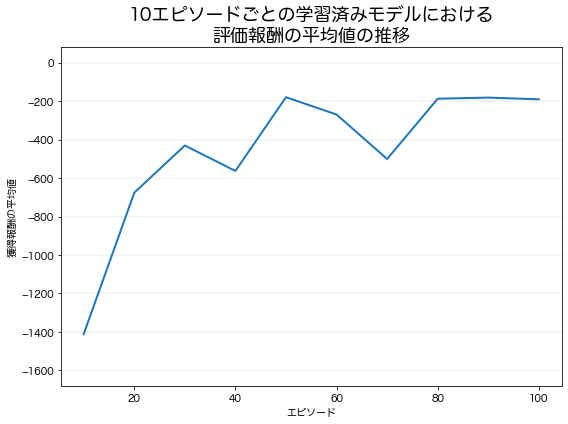

In [85]:
plt.figure(figsize=(8, 6), facecolor='white')
g = sns.lineplot(
    data=pd.DataFrame({
        'episode': range(args['eval_interval'], args['eval_interval'] * (len(eval_reward_list) + 1), args['eval_interval']),
        'reward': eval_reward_list
    }),
    x='episode', y='reward', lw=2
)
plt.title('{}エピソードごとの学習済みモデルにおける\n評価報酬の平均値の推移'.format(args['eval_interval']), fontsize=18, weight='bold')
plt.xlabel('エピソード')
plt.ylabel('獲得報酬の平均値')
for tick in plt.yticks()[0]:
    plt.axhline(tick, color='grey', alpha=0.1)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('{}_eval_reward_{}_dualnet.png'.format(gym_game_name, args['eval_interval'])), dpi=500)

## 学習済みモデルの検証

In [86]:
state = env.reset()
episode_reward = 0
done = False
while not done:
    with torch.no_grad():
        action = agent.select_action(state, evaluate=True)
    next_state, reward, done, _ = env.step(action)
    env.render()
    episode_reward += reward
    state = next_state
print('Reward: {:.2f}'.format(episode_reward))

2022-06-09 08:43:56.117 Python[26380:15080384] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/0z/jfdrd7z91lvfm8jskr77zkd40000gn/T/org.python.python.savedState


Reward: -120.63


In [87]:
result = []
for experiment_name in ['agent', 'random']:
    for i in tqdm(range(100)):

        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            if experiment_name == 'agent':
                with torch.no_grad():
                    action = agent.select_action(state, evaluate=True)
            else:
                action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state
        result.append([experiment_name, i, episode_reward])
result = pd.DataFrame(result, columns=['experiment_name', 'i', 'reward'])

100%|██████████| 100/100 [00:01<00:00, 55.86it/s]


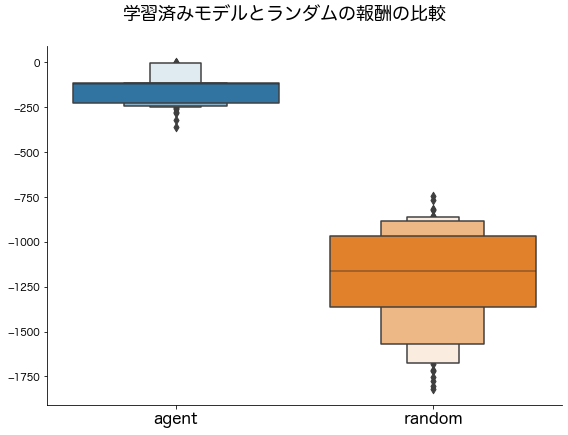

In [88]:
g = sns.catplot(data=result, x='experiment_name', y='reward', kind='boxen')
g.fig.suptitle('学習済みモデルとランダムの報酬の比較', fontsize=18, weight='bold', y=1.0)
g.fig.set_figwidth(8)
g.fig.set_figheight(6)
g.fig.set_facecolor('white')
g.set_xlabels('')
g.set_ylabels('')
g.set_xticklabels(fontsize=16)
g.tight_layout()
g.savefig(result_dir_path.joinpath(f'{gym_game_name}_reward_agent_vs_random.png'), dpi=500)

In [90]:
env = RecordVideo(gym.make(gym_game_name), './')

state = env.reset()
episode_reward = 0
done = False
while not done:
    with torch.no_grad():
        action = agent.select_action(state, evaluate=True)
    next_state, reward, done, _ = env.step(action)
    env.render()
    episode_reward += reward
    state = next_state
print('Reward: {:.2f}'.format(episode_reward))
env.close()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/satorunagata/マイドライブ（tsatoru0420@gmail.com）/knowledge/deep_reinforcement_learning/actor_critic folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Reward: -121.44


## DualNet化の制度検証

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install gputil
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [ ]:
!pip install -r requirements.txt

In [ ]:
from continuous.agents import ActorCriticModel, ActorDualCriticModel

In [ ]:
def train_agent(env, args, device, flag_cliped=0, epochs=300):

    if flag_cliped == 1:
        agent = ActorDualCriticModel(
            state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0], action_scale=env.action_space.high[0],
            args=args, device=device
        )
    else:
        agent = ActorCriticModel(
            state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0], action_scale=env.action_space.high[0],
            args=args, device=device
        )

    memory = ReplayMemory(args['memory_size'])

    episode_reward_list = []
    eval_reward_list = []

    n_steps = 0
    n_update = 0
    for i_episode in range(1, epochs + 1):

        episode_reward = 0
        done = False
        state = env.reset()

        while not done:
            
            if args['start_steps'] > n_steps:
                action = env.action_space.sample()
            else:
                action = agent.select_action(state)

            if len(memory) > args['batch_size']:
                agent.update_parameters(memory, args['batch_size'], n_update)
                n_update += 1

            next_state, reward, done, _ = env.step(action)
            n_steps += 1
            episode_reward += reward

            memory.push(state=state, action=action, reward=reward, next_state=next_state, mask=float(not done))

            state = next_state

        episode_reward_list.append(episode_reward)

        if i_episode % args['eval_interval'] == 0:
            avg_reward = 0.
            for _  in range(args['eval_interval']):
                state = env.reset()
                episode_reward = 0
                done = False
                while not done:
                    with torch.no_grad():
                        action = agent.select_action(state, evaluate=True)
                    next_state, reward, done, _ = env.step(action)
                    episode_reward += reward
                    state = next_state
                avg_reward += episode_reward
            avg_reward /= args['eval_interval']
            eval_reward_list.append(avg_reward)

    return eval_reward_list

In [ ]:
n_experiment = 10
epochs = 300
results = pd.DataFrame()
for flag_cliped in [0, 1]:
    for i in range(1, n_experiment + 1):
        eval_reward_list = train_agent(
            env=env, args=args, device=device, flag_cliped=flag_cliped, epochs=epochs
        )
        results = pd.concat([
            results,
            pd.DataFrame({
                'agent_type': ['actor_cliped_critic' if flag_cliped == 1 else 'actor_ciric'] * len(eval_reward_list),
                'loop': [i] * len(eval_reward_list),
                'n_step': np.arange(1, len(eval_reward_list) + 1),
                'reward': eval_reward_list
            })
        ], axis=0)
results.to_csv(result_dir_path.joinpath(f'{gym_game_name}_critic_vs_cliped_critic.csv'), index=False)

In [ ]:
g = sns.relplot(data=results, x='n_step', y='reward', hue='agent_type')
g.tight_layout()
g.savefig(result_dir_path.joinpath(f'{gym_game_name}_actor_critic_dualnet_or_not.png'), dpi=500)